# **CSE4022 - NATURAL LANGUAGE PROCESSING**



    > **PROJECT COMPONENT**
    TEAM MEMBERS - ILAKKIYA V (19BCE1699) and YUKTI S (19BCE1665)



In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
%cd /content/drive/My\Drive/nlp_proj

/content/drive/MyDrive/nlp_proj


In [ ]:
root = '/content/drive/MyDrive/nlp_proj/en-ta-parallel-v2/en-ta-parallel-v2'

# **Import Packages**

In [ ]:
import collections
import math
import numpy as np
import os
import random
import tensorflow as tf
import zipfile
import string
import re
import pickle

from __future__ import print_function
from matplotlib import pylab
from matplotlib.font_manager import FontProperties
from six.moves import range
from six.moves.urllib.request import urlretrieve
from sklearn.manifold import TSNE

%matplotlib inline
tam_font = FontProperties(fname=os.path.join('vijaya.ttf'))

# **Clean Data**



   > The dataset was obtained from https://ufal.mff.cuni.cz/~ramasamy/parallel/html/

They have collected English-Tamil bilingual data from some of the publicly available websites for NLP research involving Tamil. The standard set of processing has been applied on the the raw web data before the data became available in sentence aligned English-Tamil parallel corpus suitable for various NLP tasks. The parallel corpora cover texts from bible, cinema and news domains

In [ ]:
def clean_text(sentence, language):
    """
        Input: String, String
        Output: String
        Takes in text as string. Returns text cleaned for NMT purposes.
    """
    if language == None:
        print("Please enter which language.")
        return None
        
    exclude = set(string.punctuation)
    remove_digits = str.maketrans('', '', string.digits)
        
    if language == 'en':
        sentence = sentence.lower()
        sentence = ''.join(ch for ch in sentence if ch not in exclude)
        sentence = sentence.translate(remove_digits)
        sentence = sentence.strip()
        sentence = re.sub(" +", " ", sentence)
        return sentence
    
    elif language == 'ta':
        sentence = sentence.lower()
        sentence = ''.join(ch for ch in sentence if ch not in exclude)
        sentence = re.sub('[a-z]', '', sentence)
        sentence = sentence.translate(remove_digits)
        sentence = sentence.strip()
        sentence = re.sub(" +", " ", sentence)
        return sentence
    
    else:
        print("Language not found")
        return None

# **Preprocessing Data**

In [ ]:
def read_data(filename, number_of_lines):
    data = list()
    
    with open(os.path.join(root, filename)) as f:
        for i in  range(number_of_lines):
            data.extend(clean_text(tf.compat.as_str(f.readline()).strip(), 'ta').split(' '))
    return data

words = read_data('corpus.bcn.dev.ta', 5000000)
print("Data size %d" % len(words))

Data size 5014813


# **Most words in Vocabulary**

In [ ]:
vocabulary_size = int(len(set(words)) // 1.2)

def build_dataset(words):
    count = [['தமிழ்', -1]]
    count.extend(collections.Counter(words).most_common(vocabulary_size-1))
    dictionary = dict()
    
    for word, _ in count:
        dictionary[word] = len(dictionary)
    
    data = list()
    unk_count = 0
    
    for word in words:
        if word in dictionary:
            index = dictionary[word]
        else:
            index = 0
            unk_count += 1
        data.append(index)
    
    count[0][1] = unk_count
    
    reverse_dictionary = dict(zip(dictionary.values(), dictionary.keys()))
    return data, count, dictionary, reverse_dictionary

data, count, dictionary, reverse_dictionary = build_dataset(words)
print("Vocabulary size", vocabulary_size)
print("Most common words (+தமிழ்)", count[:5])
print("Sample data", data[:10])
del words

Vocabulary size 7415
Most common words (+தமிழ்) [['தமிழ்', 1485], ('', 4999003), ('மற்றும்', 163), ('ஒரு', 161), ('என்று', 120)]
Sample data [1934, 61, 970, 1935, 1936, 1937, 971, 626, 34, 1938]


# **Bag of Words**

In [ ]:
data_index = 0

def generate_batch(batch_size, bag_window):
    global data_index
    span = 2 * bag_window + 1
    batch = np.ndarray(shape=(batch_size, span-1), dtype=np.int32)
    labels = np.ndarray(shape=(batch_size, 1), dtype=np.int32)
    buffer = collections.deque(maxlen=span)
    
    for _ in range(span):
        buffer.append(data[data_index])
        data_index = (data_index + 1) % len(data)
    
    for i in range(batch_size):
        buffer_list = list(buffer)
        labels[i, 0] = buffer_list.pop(bag_window)
        batch[i] = buffer_list
        
        buffer.append(data[data_index])
        data_index = (data_index + 1) % len(data)
    return batch, labels

print('Data:', [reverse_dictionary[di] for di in data[:16]])

for bag_window in [1, 2]:
    data_index = 0
    batch, labels = generate_batch(batch_size=4, bag_window=bag_window)
    print("\nwith bag_window = %d:" % (bag_window))
    print(" batch:", [[reverse_dictionary[w] for w in bi] for bi in batch])
    print(" label:", [reverse_dictionary[li] for li in labels.reshape(4)])

Data: ['சவுலுக்கு', 'இருந்த', 'குமாரர்', 'யோனத்தான்', 'இஸ்வி', 'மல்கிசூவா', 'என்பவர்கள்', 'அவனுடைய', 'இரண்டு', 'குமாரத்திகளில்', 'மூத்தவள்', 'பேர்', 'மோப்', 'இளையவள்', 'பேர்', 'மீகாள்']

with bag_window = 1:
 batch: [['சவுலுக்கு', 'குமாரர்'], ['இருந்த', 'யோனத்தான்'], ['குமாரர்', 'இஸ்வி'], ['யோனத்தான்', 'மல்கிசூவா']]
 label: ['இருந்த', 'குமாரர்', 'யோனத்தான்', 'இஸ்வி']

with bag_window = 2:
 batch: [['சவுலுக்கு', 'இருந்த', 'யோனத்தான்', 'இஸ்வி'], ['இருந்த', 'குமாரர்', 'இஸ்வி', 'மல்கிசூவா'], ['குமாரர்', 'யோனத்தான்', 'மல்கிசூவா', 'என்பவர்கள்'], ['யோனத்தான்', 'இஸ்வி', 'என்பவர்கள்', 'அவனுடைய']]
 label: ['குமாரர்', 'யோனத்தான்', 'இஸ்வி', 'மல்கிசூவா']


# **Tensorflow implementation**

In [ ]:
import tensorflow.compat.v1 as tf
tf.disable_v2_behavior()
batch_size = 128
embedding_size = 128
bag_window = 2
valid_size = 16
valid_window = 100
valid_examples = np.array(random.sample(range(valid_window), valid_size))
num_sampled = 64

graph = tf.Graph()

with graph.as_default(), tf.device('/cpu:0'):
    train_dataset = tf.placeholder(tf.int32, shape=[batch_size, bag_window * 2])
    train_labels = tf.placeholder(tf.int32, shape=[batch_size, 1])
    valid_dataset = tf.constant(valid_examples, dtype=tf.int32)
    
    embeddings = tf.Variable(tf.random_uniform([vocabulary_size, embedding_size], -1.0, 1.0))
    softmax_weights = tf.Variable(tf.truncated_normal([vocabulary_size, embedding_size], stddev=1.0 / math.sqrt(embedding_size)))
    softmax_biases = tf.Variable(tf.zeros([vocabulary_size]))
    
    embeds = tf.nn.embedding_lookup(embeddings, train_dataset)
    loss = tf.reduce_mean(tf.nn.sampled_softmax_loss(weights=softmax_weights, biases=softmax_biases, 
                                                     inputs=tf.reduce_sum(embeds, 1), labels=train_labels, 
                                                     num_sampled=num_sampled, num_classes=vocabulary_size))
    
    optimizer = tf.train.AdagradOptimizer(1.0).minimize(loss)
    
    norm = tf.sqrt(tf.reduce_sum(tf.square(embeddings), 1, keepdims=True))
    normalized_embeddings = embeddings / norm
    valid_embeddings = tf.nn.embedding_lookup(normalized_embeddings, valid_dataset)
    similarity = tf.matmul(valid_embeddings, tf.transpose(normalized_embeddings))

Instructions for updating:
non-resource variables are not supported in the long term
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


In [ ]:
num_steps = 100001

with tf.Session(graph=graph) as session:
    tf.initialize_all_variables().run()
    print("Initialized")
    average_loss = 0
    
    for step in range(num_steps):
        batch_data, batch_labels = generate_batch(batch_size, bag_window)
        feed_dict = {train_dataset: batch_data, train_labels: batch_labels}
        _, l = session.run([optimizer, loss], feed_dict=feed_dict)
        average_loss += l
        
        if step % 2000 == 0:
            if step > 0:
                average_loss = average_loss / 2000
            print("Average loss at step %d: %f" % (step, average_loss))
            average_loss = 0
        
        if step % 10000 == 0:
            sim = similarity.eval()
            for i in range(valid_size):
                valid_word = reverse_dictionary[valid_examples[i]]
                top_k = 8
                nearest = (-sim[i, :]).argsort()[1:top_k + 1]
                log = "Nearest to %s:" % valid_word
                
                for k in range(top_k):
                    close_word = reverse_dictionary[nearest[k]]
                    log = "%s %s" % (log, close_word)
                print(log)
    final_embeddings = normalized_embeddings.eval()

Instructions for updating:
Use `tf.global_variables_initializer` instead.
Initialized
Average loss at step 0: 5.296498
Nearest to என்றும்: நேரிடுவதாக மேற்கோளிட்டுள்ளது மிகப்பெருமளவில் ஆயுதங்களைப் கண்டாயா தொழில்துறை முன்வைத்தலை மனுஷன்
Nearest to ஆகும்: ஆர்ப்பாட்டமானது திட்டமிட்டுள்ளனர் ஒப்பந்ததத்தில் நான்கில் இன்னமும் தற்சமயம் டைரக்டர் புல்
Nearest to தொழிலாள: அவர்களுக்குக் அணிந்த சிக்கன முஷாரப் மையத்தின் துகள்களால் பின்பற்றப்படும் இயக்குனர்களை
Nearest to மீது: மே சுவீடனும் ஊடுருவலையும் உடைத்துவிடப் பெற்றான் உடனான துறைமுகம் ஈசோப்பையும்
Nearest to அவரது: என்னவெனில் தொடர்ந்து மீதியானவர்களும் டசின்கணக்கான படுமோசமாக மற்றொருபடம் வெளிவந்திருக்கின்றன குண்டுகள்
Nearest to பற்றிய: பேரணிகளில் அரசாங்கத்தின் தங்கை வெளியேறினேன் தகடு முழுமையாக குறைந்தபட்ச குக்
Nearest to கொண்டு: லாரன்ஸ் சாத்தியமானது மையமாக கூறக் இருந்தால் விக்கிரமசிங்க நடவடிக்கைகளோடு குடிமக்களாக
Nearest to ல்: செவிலியர்கள் வெளியான சிறுமி கோழைகளைக் விருப்பதற்கு திரையில் அனைத்திற்காகவும் அமைந்திருக்கிறது
Nearest to தங்கள்: மாதம்

# **Visualization of the output**

In [ ]:
num_points = 400

tsne = TSNE(perplexity=30, n_components=2, init='pca', n_iter=5000, method='exact')
two_d_embeddings = tsne.fit_transform(final_embeddings[1:num_points+1, :])

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:986: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  FutureWarning,


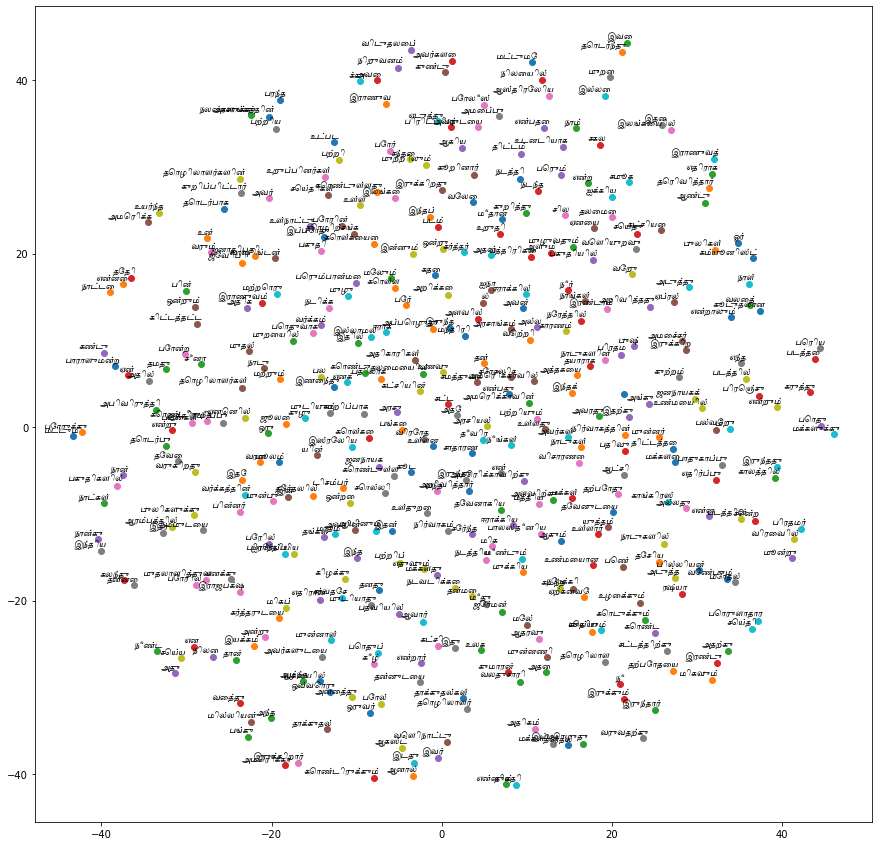

In [ ]:
def plot(embeddings, labels):
    assert embeddings.shape[0] >= len(labels), 'More labels than embeddings'
    pylab.figure(figsize=(15, 15))
    for i, label in enumerate(labels):
        x, y = embeddings[i, :]
        pylab.scatter(x, y)
        pylab.annotate(label, xy=(x, y), xytext=(5, 2), textcoords='offset points', ha='right', va='bottom', fontproperties=tam_font)
    pylab.show()

words = [reverse_dictionary[i] for i in range(1, num_points+1)]
plot(two_d_embeddings, words)

# **Sve pickle file of tamil embeddings**

In [ ]:
final_data = {
    'embeddings': final_embeddings,
    'dictionary': dictionary,
    'reverse_dictionary': reverse_dictionary
}

In [ ]:
with open(os.path.join('embeddings_cbow.ta'), 'wb') as f:
    pickle.dump(file=f, obj=final_data)

In [ ]:
np.save((os.path.join('embeddings_cbow.npy')), final_data)

In [ ]:
data = np.load(('embeddings_cbow.npy'),allow_pickle=True)

In [ ]:
embeddings = data[()]['embeddings']
idx_to_game = data[()]['reverse_dictionary']
game_to_idx = data[()]['dictionary']

# **Measure Cosine distance and find closest words**

In [ ]:
def closest(u, count=8):
    closest = []
    for idx, game in enumerate(idx_to_game):
        closest.append((idx, distance.cosine(u, embeddings[idx])))
    return closest

def closest_to_game(game, count=8):
    return closest(embeddings[game_to_idx[game]], count)

def game_distance(a, b):
    return distance.cosine(embeddings[game_to_idx[a]], embeddings[game_to_idx[b]])

In [ ]:
print('Cosine: {}'.format(distance.cosine(embeddings[game_to_idx['தமிழ்']], embeddings[game_to_idx['ஒரு']])))
print('Euclidean: {}'.format(distance.euclidean(embeddings[game_to_idx['தமிழ்']], embeddings[game_to_idx['ஒரு']])))
print('Squared eucliedean: {}'.format(distance.sqeuclidean(embeddings[game_to_idx['தமிழ்']], embeddings[game_to_idx['ஒரு']])))
print('Correlation: {}'.format(distance.correlation(embeddings[game_to_idx['தமிழ்']], embeddings[game_to_idx['ஒரு']])))

Cosine: 0.7798942029476166
Euclidean: 1.2489148378372192
Squared eucliedean: 1.559788465499878
Correlation: 0.739003598690033


In [ ]:
closest2 = closest_to_game('அவர்', 8)
x = sorted(closest2, key=lambda t: t[1],reverse=True)
for i in range(8):
  print(idx_to_game[x[i][0]],',',x[i][1],end='\n')
#closest_to_game(1, 8)
#return closest(embeddings[game_to_idx[game]], count)

சேர்த்துக் , 1.3678403794765472
பங்காற்றின , 1.3149825632572174
உயிரிழந்தார் , 1.2995618283748627
அலுவலகத்திற்கு , 1.2969089448451996
அவளுக்குப் , 1.2951366901397705
பேர்பெற்ற , 1.293010413646698
பெருகி , 1.2850809395313263
ஞானவேல் , 1.2745023667812347


In [ ]:
closest3 = closest_to_game('அரசியல்', 8)
x = sorted(closest3, key=lambda t: t[1],reverse=True)
for i in range(8):
  print(idx_to_game[x[i][0]],',',x[i][1],end='\n')

தடுப்புக்காவல் , 1.2979064583778381
முகத்துடன் , 1.2804172039031982
முதல்முறையாக , 1.2801902294158936
உடனேயே , 1.2749870717525482
ஜனவரி , 1.2716169655323029
வந்ததில் , 1.2700728178024292
நேரியின் , 1.2669887840747833
கட்சிக்காரர்கள் , 1.2634806632995605


# **Conclusion**

